In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from sklearn.metrics import silhouette_samples, silhouette_score

movies = pd.read_csv('data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# Import the ratings dataset
ratings = pd.read_csv('data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
    genre_ratings.columns = column_names
    return genre_ratings

In [8]:
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
userId,,
1,3.50,2.40
2,3.59,3.80
3,3.65,3.14
4,4.50,4.26
5,4.08,4.00


In [9]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

In [10]:
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  183


,userId,avg_romance_rating,avg_scifi_rating
0,1,3.50,2.40
1,3,3.65,3.14
2,6,2.90,2.75
3,7,2.93,3.36
4,12,2.89,2.62


In [12]:
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

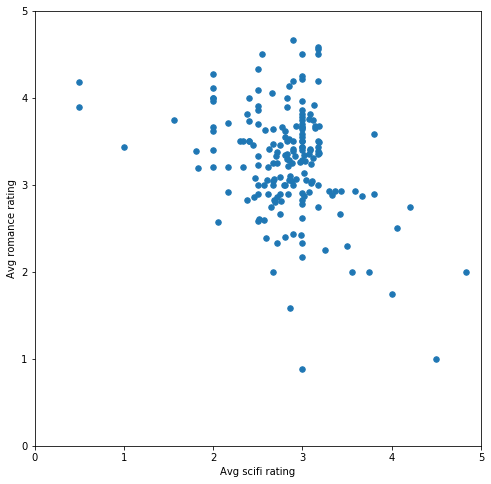

In [14]:
%matplotlib inline
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

In [15]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

In [16]:
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

In [24]:
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

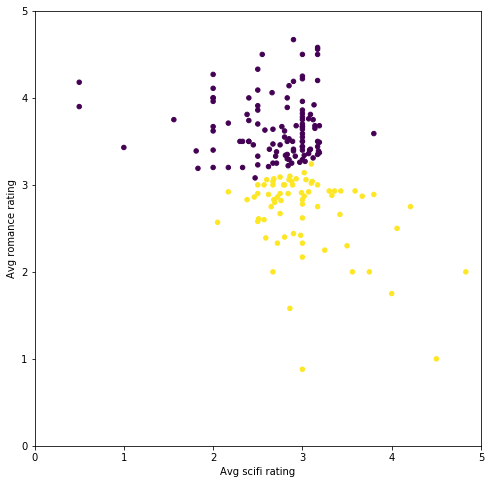

In [17]:
kmeans_1 = KMeans(n_clusters=2, random_state=0)
predictions = kmeans_1.fit_predict(X)
draw_clusters(biased_dataset, predictions)

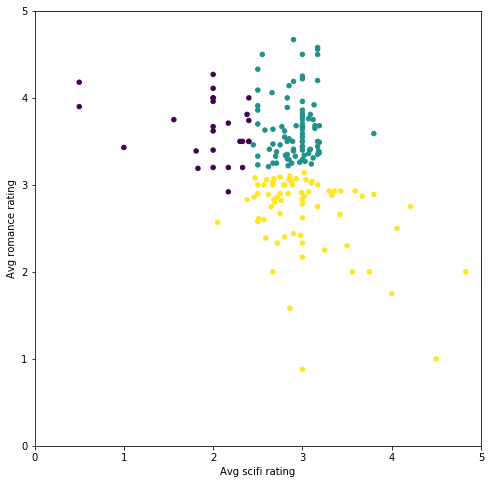

In [18]:
kmeans_2 = KMeans(n_clusters=3, random_state=1)
predictions_2 = kmeans_2.fit_predict(X)
draw_clusters(biased_dataset, predictions_2)

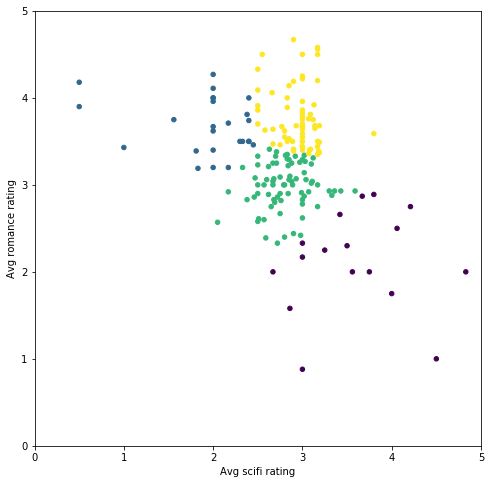

In [19]:
kmeans_3 = KMeans(n_clusters=4, random_state=3)
predictions_3 = kmeans_3.fit_predict(X)
draw_clusters(biased_dataset, predictions_3)

In [25]:
# Choose the range of k values to test.
possible_k_values = range(2, len(X)+1, 5)
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

/home/hp/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (178) found smaller than n_clusters (182). Possibly due to duplicate points in X.
  return_n_iter=True)


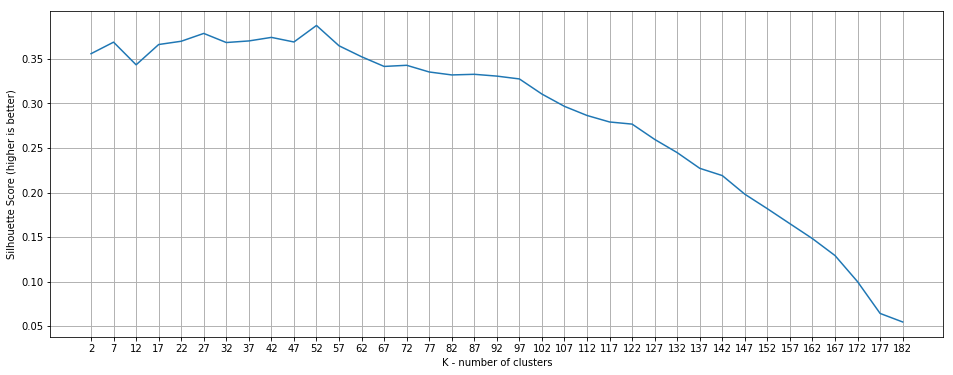

In [26]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

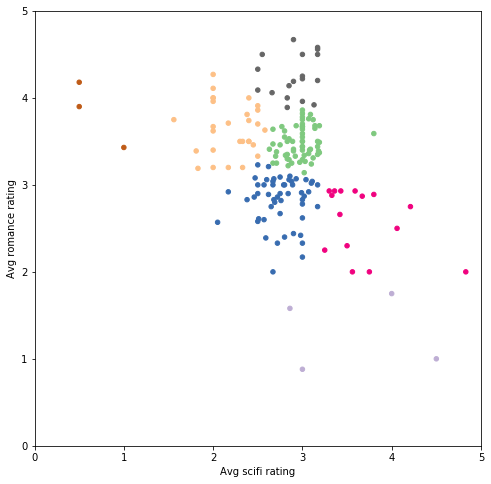

In [27]:
#Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7, random_state=6)
predictions_4 = kmeans_4.fit_predict(X)
draw_clusters(biased_dataset, predictions_4, cmap='Accent') 

In [29]:
biased_dataset_3_genres = get_genre_ratings(ratings, movies, 
                                                     ['Romance', 'Sci-Fi', 'Action'], 
                                                     ['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  183


,userId,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,1,3.50,2.40,2.80
1,3,3.65,3.14,3.47
2,6,2.90,2.75,3.27
3,7,2.93,3.36,3.29
4,12,2.89,2.62,3.21


In [30]:
X_with_action = biased_dataset_3_genres[['avg_scifi_rating',
                                         'avg_romance_rating', 
                                         'avg_action_rating']].values

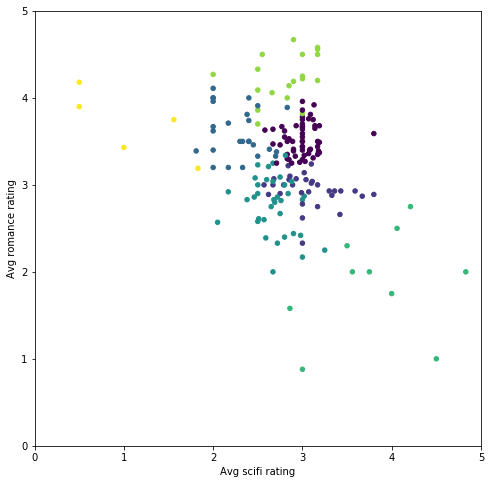

In [32]:
# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
predictions_5 = kmeans_5.fit_predict(X_with_action)

draw_clusters(biased_dataset_3_genres, predictions_5)

In [33]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (671, 9064) 

Subset example:


title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


In [34]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [36]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [38]:
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    return most_rated_movies_users_selection

In [39]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Dances with Wolves (1990),Fight Club (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),"Lion King, The (1994)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Apollo 13 (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
29,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,...,5.0,4.0,5.0,4.0,3.0,5.0,3.0,5.0,4.0,2.0
508,4.0,5.0,4.0,4.0,5.0,3.0,4.5,3.0,5.0,2.0,...,5.0,4.0,5.0,4.0,3.5,5.0,4.5,3.0,2.0,4.0
14,1.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,4.0,4.0,...,3.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,4.0
72,5.0,5.0,5.0,4.5,4.5,4.0,4.5,5.0,5.0,3.0,...,4.5,5.0,5.0,5.0,5.0,5.0,5.0,3.5,3.0,5.0
653,4.0,5.0,5.0,4.5,5.0,4.5,5.0,5.0,5.0,5.0,...,4.5,5.0,5.0,4.5,5.0,4.5,5.0,5.0,4.0,5.0


In [40]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [41]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

In [42]:
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

In [43]:
max_users = 70
max_movies = 50
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [45]:
cluster_number = 4

# filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)


In [46]:
cluster.fillna('').head()

,"Matrix, The (1999)","Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Fellowship of the Ring, The (2001)","Lord of the Rings: The Return of the King, The (2003)","Dark Knight, The (2008)",Forrest Gump (1994),Pulp Fiction (1994),Fight Club (1999),Shrek (2001),Inception (2010),...,Wallace & Gromit in The Curse of the Were-Rabbit (2005),Signs (2002),Pearl Harbor (2001),National Treasure (2004),Back to the Future Part III (1990),Terminator 3: Rise of the Machines (2003),L.A. Confidential (1997),Jerry Maguire (1996),12 Angry Men (1957),"South Park: Bigger, Longer and Uncut (1999)"
61,4.5,4,3.5,4,4.5,4,5,4.5,4,4,...,,,1.5,,,3,,,,
46,5,5,5,5,5,4.5,5,5,2,3,...,,3,2,2.5,,1,,,5,
16,4.5,3.5,3.5,3.5,4.5,,4,4.5,3,4.5,...,,,2.5,,3.5,3,,,,
4,4.5,4,4.5,4,4,4,4.5,5,4,4,...,3.5,3.5,,,,,,,,3.5
15,5,4,4,4,4.5,3,4.5,4.5,3,4.5,...,,,,,,,,,,


In [47]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Matrix, The (1999)                                               4.306452
Lord of the Rings: The Two Towers, The (2002)                    4.017544
Lord of the Rings: The Fellowship of the Ring, The (2001)        3.982456
Lord of the Rings: The Return of the King, The (2003)            4.063636
Dark Knight, The (2008)                                          4.307692
Forrest Gump (1994)                                              4.200000
Pulp Fiction (1994)                                              4.416667
Fight Club (1999)                                                4.322917
Shrek (2001)                                                     3.718750
Inception (2010)                                                 4.053191
Pirates of the Caribbean: The Curse of the Black Pearl (2003)    3.777778
Batman Begins (2005)                                             4.033333
Star Wars: Episode IV - A New Hope (1977)                        4.102273
Incredibles, The (2004)               

In [48]:
user_id = 2
user_2_ratings  = cluster.loc[user_id, :]
user_2_ratings

Matrix, The (1999)                                               4.0
Lord of the Rings: The Two Towers, The (2002)                    4.5
Lord of the Rings: The Fellowship of the Ring, The (2001)        4.0
Lord of the Rings: The Return of the King, The (2003)            4.5
Dark Knight, The (2008)                                          4.5
Forrest Gump (1994)                                              4.5
Pulp Fiction (1994)                                              5.0
Fight Club (1999)                                                4.0
Shrek (2001)                                                     NaN
Inception (2010)                                                 4.0
Pirates of the Caribbean: The Curse of the Black Pearl (2003)    4.0
Batman Begins (2005)                                             4.0
Star Wars: Episode IV - A New Hope (1977)                        NaN
Incredibles, The (2004)                                          NaN
Back to the Future (1985)         

In [49]:
# Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 2

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

12 Angry Men (1957)                                                          4.611111
Game, The (1997)                                                             4.550000
Breakfast Club, The (1985)                                                   4.500000
Howl's Moving Castle (Hauru no ugoku shiro) (2004)                           4.450000
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)    4.409091
Intouchables (2011)                                                          4.366667
Office Space (1999)                                                          4.321429
Harry Potter and the Deathly Hallows: Part 2 (2011)                          4.312500
Ferris Bueller's Day Off (1986)                                              4.300000
City of God (Cidade de Deus) (2002)                                          4.295455
Prestige, The (2006)                                                         4.291667
Usual Suspects, The (1995)                            